# Implementasi Cross Validation

Dalam notebook ini, kita akan mengimplementasikan Cross Validation dalam berbagai skenario praktis:

1. **Hyperparameter Tuning**
   - Grid Search CV
   - Random Search CV
   - Nested Cross Validation

2. **Model Selection**
   - Membandingkan berbagai algoritma
   - Feature selection dengan CV
   - Ensemble methods

3. **Kasus Khusus**
   - Time series forecasting
   - Imbalanced classification
   - Multi-label classification

4. **Advanced Techniques**
   - Custom scoring metrics
   - Pipeline dengan preprocessing
   - Parallel processing

Mari kita mulai dengan import library yang diperlukan.

In [87]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import (
    train_test_split, cross_val_score, 
    GridSearchCV, RandomizedSearchCV, 
    KFold, StratifiedKFold
)
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    mean_squared_error, make_scorer
)
from sklearn.ensemble import (
    RandomForestClassifier, GradientBoostingClassifier,
    RandomForestRegressor
)
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.feature_selection import SelectKBest, f_classif

# Set random seed
np.random.seed(42)

# 1. Hyperparameter Tuning dengan Cross Validation

## Grid Search CV
- Mencoba semua kombinasi hyperparameter
- Systematic approach
- Computationally expensive
- Best untuk parameter space yang kecil

## Random Search CV
- Sampling random dari parameter space
- Lebih efisien untuk parameter space besar
- Bisa menemukan kombinasi yang baik dengan lebih cepat
- Tidak menjamin menemukan kombinasi terbaik

Mari kita implementasikan kedua metode ini dan bandingkan hasilnya.

Melakukan Grid Search...
Fitting 5 folds for each of 108 candidates, totalling 540 fits



Melakukan Random Search...
Fitting 5 folds for each of 20 candidates, totalling 100 fits



Grid Search Results:
--------------------
Best CV Score: 0.9626
Test Score: 0.9649
Mean Fit Time: 0.54 seconds

Best Parameters:
classifier__max_depth: 10
classifier__min_samples_leaf: 1
classifier__min_samples_split: 2
classifier__n_estimators: 200

Random Search Results:
--------------------
Best CV Score: 0.9582
Test Score: 0.9649
Mean Fit Time: 0.61 seconds

Best Parameters:
classifier__n_estimators: 100
classifier__min_samples_split: 5
classifier__min_samples_leaf: 2
classifier__max_depth: None


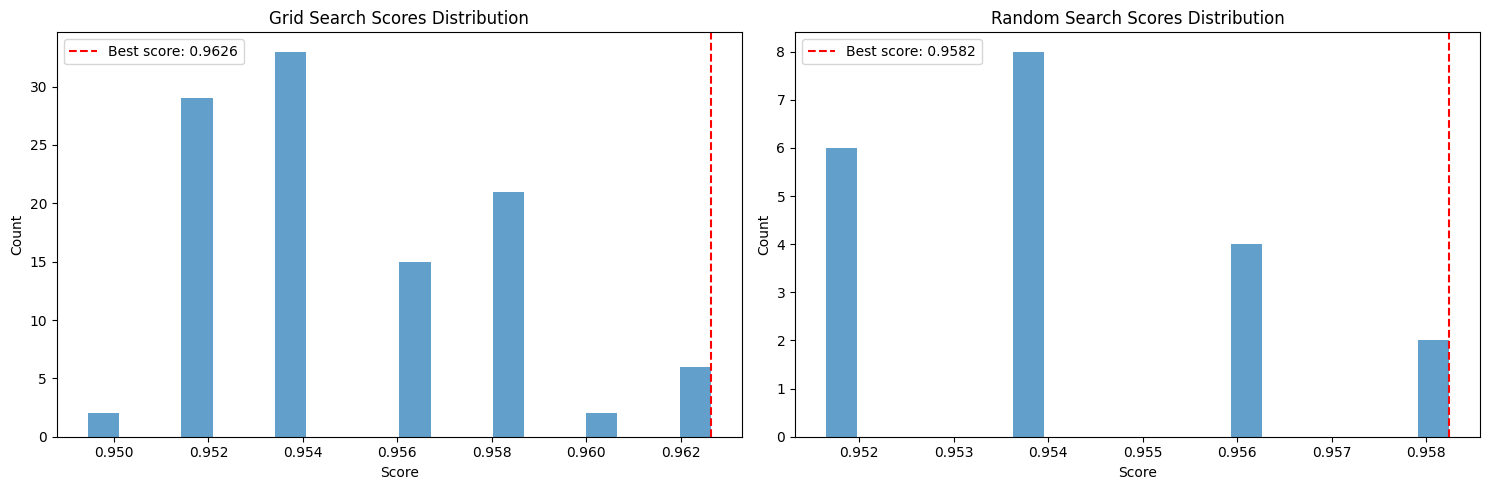

In [88]:
# Load dataset
from sklearn.datasets import load_breast_cancer
X, y = load_breast_cancer(return_X_y=True)

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Pipeline untuk preprocessing dan model
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Parameter grid untuk Grid Search
param_grid = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [5, 10, 15, None],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4]
}

# Parameter distribution untuk Random Search
param_dist = {
    'classifier__n_estimators': np.arange(100, 400, 50),
    'classifier__max_depth': [5, 10, 15, None],
    'classifier__min_samples_split': np.arange(2, 11),
    'classifier__min_samples_leaf': np.arange(1, 5)
}

# Grid Search CV
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

print("Melakukan Grid Search...")
grid_search.fit(X_train, y_train)

# Random Search CV
random_search = RandomizedSearchCV(
    pipeline,
    param_dist,
    n_iter=20,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1,
    random_state=42
)

print("\nMelakukan Random Search...")
random_search.fit(X_train, y_train)

# Bandingkan hasil
def compare_search_results(grid_search, random_search):
    results = {
        'Grid Search': {
            'Best Score': grid_search.best_score_,
            'Best Params': grid_search.best_params_,
            'Test Score': grid_search.score(X_test, y_test),
            'Fit Time': grid_search.cv_results_['mean_fit_time'].mean()
        },
        'Random Search': {
            'Best Score': random_search.best_score_,
            'Best Params': random_search.best_params_,
            'Test Score': random_search.score(X_test, y_test),
            'Fit Time': random_search.cv_results_['mean_fit_time'].mean()
        }
    }
    
    # Print results
    for method, metrics in results.items():
        print(f"\n{method} Results:")
        print("-" * 20)
        print(f"Best CV Score: {metrics['Best Score']:.4f}")
        print(f"Test Score: {metrics['Test Score']:.4f}")
        print(f"Mean Fit Time: {metrics['Fit Time']:.2f} seconds")
        print("\nBest Parameters:")
        for param, value in metrics['Best Params'].items():
            print(f"{param}: {value}")
    
    return results

results = compare_search_results(grid_search, random_search)

# Visualisasi hasil
def plot_search_results(grid_search, random_search):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot Grid Search scores
    grid_scores = grid_search.cv_results_['mean_test_score']
    ax1.hist(grid_scores, bins=20, alpha=0.7)
    ax1.axvline(grid_search.best_score_, color='r', linestyle='--', 
                label=f'Best score: {grid_search.best_score_:.4f}')
    ax1.set_title('Grid Search Scores Distribution')
    ax1.set_xlabel('Score')
    ax1.set_ylabel('Count')
    ax1.legend()
    
    # Plot Random Search scores
    random_scores = random_search.cv_results_['mean_test_score']
    ax2.hist(random_scores, bins=20, alpha=0.7)
    ax2.axvline(random_search.best_score_, color='r', linestyle='--',
                label=f'Best score: {random_search.best_score_:.4f}')
    ax2.set_title('Random Search Scores Distribution')
    ax2.set_xlabel('Score')
    ax2.set_ylabel('Count')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()

plot_search_results(grid_search, random_search)

# 2. Model Selection dengan Cross Validation

Dalam bagian ini, kita akan:
1. Membandingkan berbagai algoritma menggunakan CV
2. Implementasi feature selection dengan CV
3. Menggunakan custom scoring metrics
4. Menerapkan nested cross-validation

Mari kita mulai dengan membandingkan beberapa model klasifikasi.

Evaluating models...


/tmp/ipykernel_48728/1099894791.py:57: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[idx].set_xticklabels(model_names, rotation=45)
/tmp/ipykernel_48728/1099894791.py:57: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[idx].set_xticklabels(model_names, rotation=45)
/tmp/ipykernel_48728/1099894791.py:57: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[idx].set_xticklabels(model_names, rotation=45)
/tmp/ipykernel_48728/1099894791.py:57: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[idx].set_xticklabels(model_names, rotation=45)


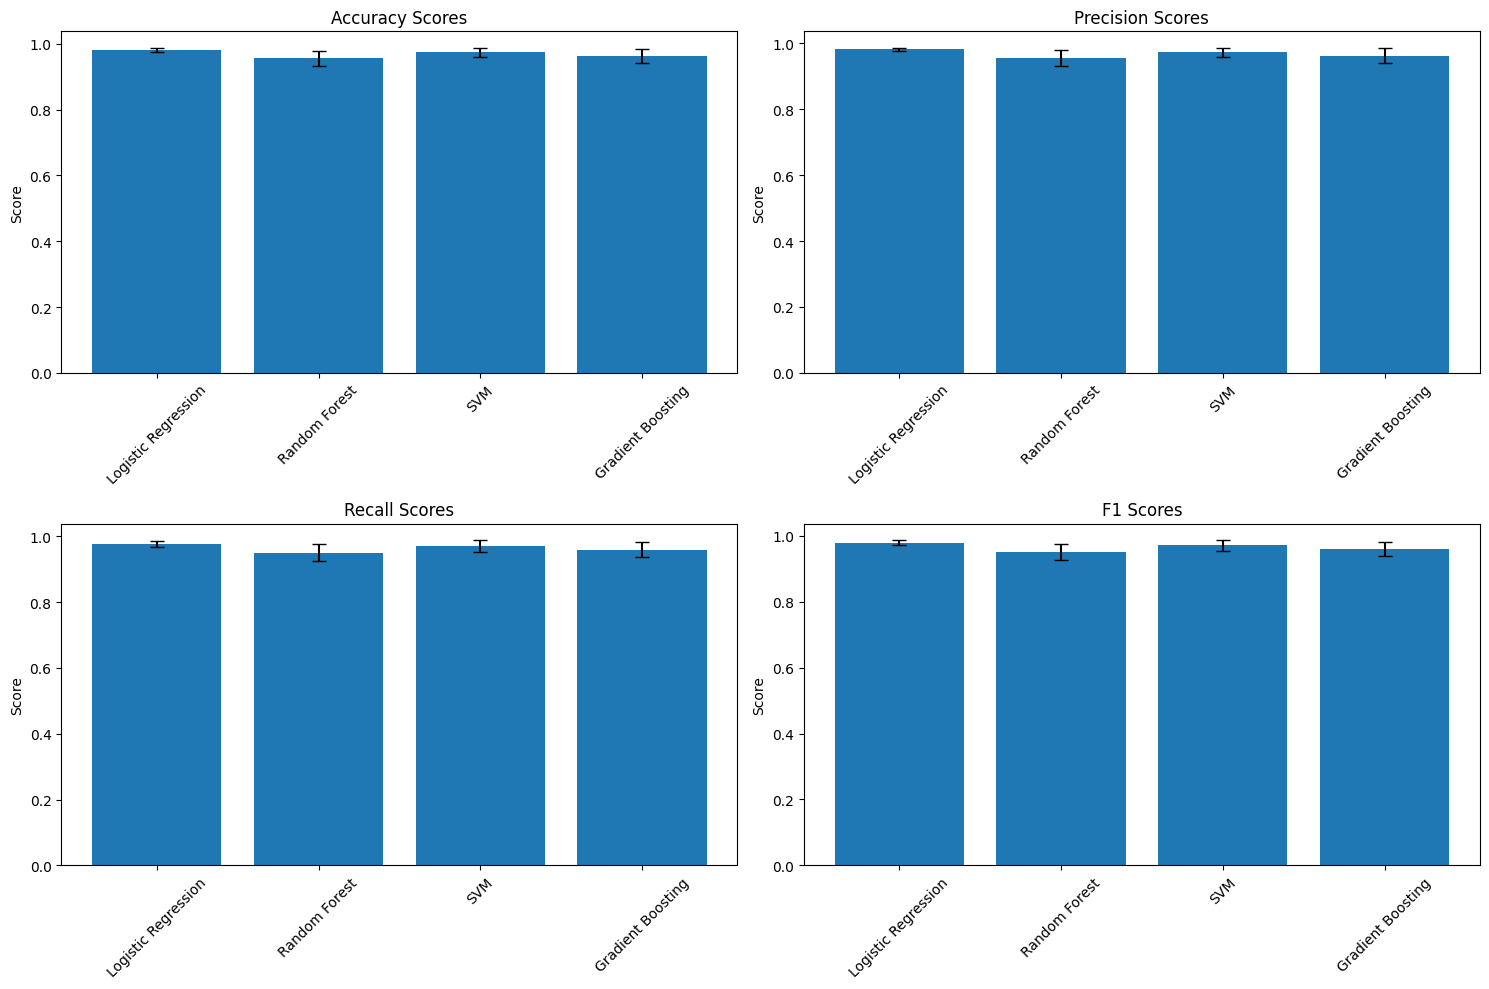


Detailed Model Comparison:
--------------------------------------------------

Logistic Regression:
accuracy: 0.9807 (+/- 0.0131)
precision: 0.9820 (+/- 0.0100)
recall: 0.9769 (+/- 0.0199)
f1: 0.9792 (+/- 0.0144)

Random Forest:
accuracy: 0.9561 (+/- 0.0457)
precision: 0.9560 (+/- 0.0467)
recall: 0.9508 (+/- 0.0516)
f1: 0.9528 (+/- 0.0487)

SVM:
accuracy: 0.9736 (+/- 0.0294)
precision: 0.9735 (+/- 0.0274)
recall: 0.9704 (+/- 0.0363)
f1: 0.9717 (+/- 0.0318)

Gradient Boosting:
accuracy: 0.9631 (+/- 0.0420)
precision: 0.9626 (+/- 0.0446)
recall: 0.9592 (+/- 0.0448)
f1: 0.9605 (+/- 0.0445)


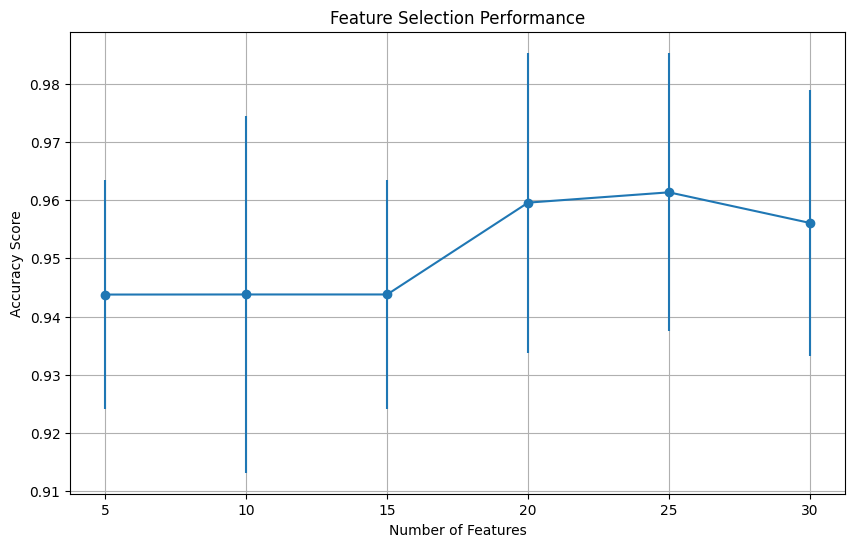


Optimal number of features: 25
Best accuracy: 0.9614 (+/- 0.0478)


In [89]:
# Fungsi untuk evaluasi model dengan multiple metrics
def evaluate_models(models, X, y, cv=5):
    results = {}
    scoring = {
        'accuracy': 'accuracy',
        'precision': 'precision_macro',
        'recall': 'recall_macro',
        'f1': 'f1_macro'
    }
    
    for name, model in models.items():
        # Create pipeline
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('model', model)
        ])
        
        # Calculate scores
        cv_scores = {}
        for metric_name, scorer in scoring.items():
            scores = cross_val_score(pipeline, X, y, cv=cv, scoring=scorer)
            cv_scores[metric_name] = {
                'mean': scores.mean(),
                'std': scores.std()
            }
        
        results[name] = cv_scores
    
    return results

# Define models to compare
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(random_state=42),
    'SVM': SVC(probability=True, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42)
}

# Evaluate models
print("Evaluating models...")
model_results = evaluate_models(models, X, y)

# Visualize results
def plot_model_comparison(results):
    metrics = list(next(iter(results.values())).keys())
    model_names = list(results.keys())
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    axes = axes.ravel()
    
    for idx, metric in enumerate(metrics):
        means = [results[model][metric]['mean'] for model in model_names]
        stds = [results[model][metric]['std'] for model in model_names]
        
        axes[idx].bar(model_names, means, yerr=stds, capsize=5)
        axes[idx].set_title(f'{metric.capitalize()} Scores')
        axes[idx].set_xticklabels(model_names, rotation=45)
        axes[idx].set_ylabel('Score')
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed results
    print("\nDetailed Model Comparison:")
    print("-" * 50)
    for model in model_names:
        print(f"\n{model}:")
        for metric in metrics:
            mean = results[model][metric]['mean']
            std = results[model][metric]['std']
            print(f"{metric}: {mean:.4f} (+/- {std*2:.4f})")

plot_model_comparison(model_results)

# Feature Selection dengan CV
def feature_selection_cv(X, y, k_features=10):
    # Create pipeline with feature selection
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('feature_selector', SelectKBest(f_classif, k=k_features)),
        ('classifier', RandomForestClassifier(random_state=42))
    ])
    
    # Cross-validation scores
    scores = cross_val_score(pipeline, X, y, cv=5, scoring='accuracy')
    
    # Fit pipeline to get selected features
    pipeline.fit(X, y)
    feature_mask = pipeline.named_steps['feature_selector'].get_support()
    
    return scores, feature_mask

# Try different numbers of features
k_features_range = [5, 10, 15, 20, 25, 30]
feature_selection_results = []

for k in k_features_range:
    scores, _ = feature_selection_cv(X, y, k)
    feature_selection_results.append({
        'k': k,
        'mean_score': scores.mean(),
        'std_score': scores.std()
    })

# Plot feature selection results
plt.figure(figsize=(10, 6))
means = [r['mean_score'] for r in feature_selection_results]
stds = [r['std_score'] for r in feature_selection_results]

plt.errorbar(k_features_range, means, yerr=stds, marker='o')
plt.xlabel('Number of Features')
plt.ylabel('Accuracy Score')
plt.title('Feature Selection Performance')
plt.grid(True)
plt.show()

# Print optimal number of features
best_k = k_features_range[np.argmax(means)]
print(f"\nOptimal number of features: {best_k}")
print(f"Best accuracy: {max(means):.4f} (+/- {stds[np.argmax(means)]*2:.4f})")

# 3. Kasus Khusus: Time Series Cross Validation

Untuk data time series, kita perlu menggunakan teknik CV khusus untuk:
1. Menghindari data leakage
2. Mempertahankan urutan temporal
3. Mensimulasikan prediksi real-world

Mari kita implementasikan time series CV dengan contoh data.

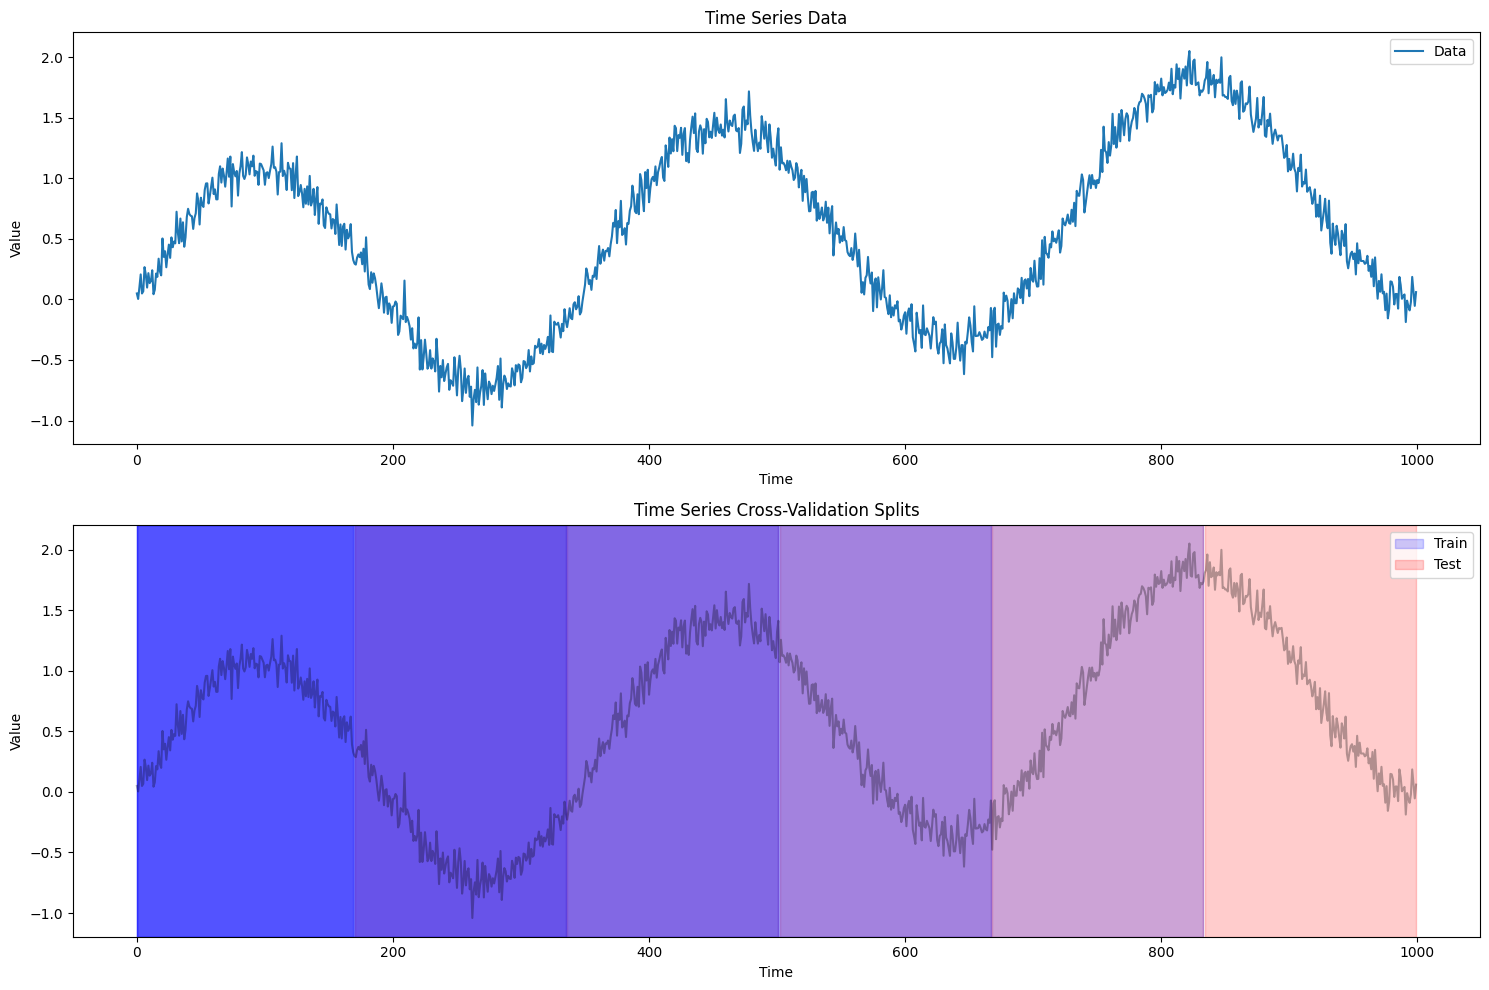

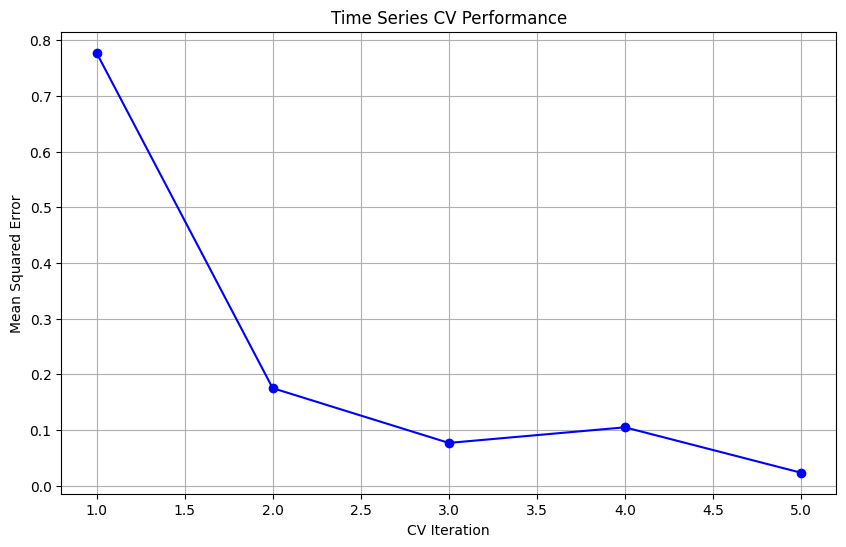


Time Series CV Results:
Mean MSE: 0.231426
Std MSE: 0.277409

MSE per fold:
Fold 1: 0.777520
Fold 2: 0.175086
Fold 3: 0.076691
Fold 4: 0.104688
Fold 5: 0.023144


In [90]:
# Generate synthetic time series data
from sklearn.model_selection import TimeSeriesSplit
import numpy as np

# Create time series data
n_samples = 1000
time = np.arange(n_samples)
trend = 0.001 * time
seasonal = np.sin(2 * np.pi * time / 365.25)  # Yearly seasonality
noise = np.random.normal(0, 0.1, n_samples)
y_time = trend + seasonal + noise

# Create features
X_time = np.column_stack([
    time,  # Time index
    np.sin(2 * np.pi * time / 365.25),  # Sine of yearly cycle
    np.cos(2 * np.pi * time / 365.25),  # Cosine of yearly cycle
])

# Time Series CV
tscv = TimeSeriesSplit(n_splits=5)

# Visualize splits
def plot_time_series_cv(X, y, cv):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))
    
    # Plot the data
    ax1.plot(X[:, 0], y, label='Data')
    ax1.set_title('Time Series Data')
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Value')
    ax1.legend()
    
    # Plot the CV splits
    for i, (train_idx, test_idx) in enumerate(cv.split(X)):
        train_start = X[train_idx[0], 0]
        train_end = X[train_idx[-1], 0]
        test_start = X[test_idx[0], 0]
        test_end = X[test_idx[-1], 0]
        
        ax2.axvspan(train_start, train_end, alpha=0.2, color='blue', label='Train' if i==0 else "")
        ax2.axvspan(test_start, test_end, alpha=0.2, color='red', label='Test' if i==0 else "")
    
    ax2.plot(X[:, 0], y, 'k-', alpha=0.3)
    ax2.set_title('Time Series Cross-Validation Splits')
    ax2.set_xlabel('Time')
    ax2.set_ylabel('Value')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()

plot_time_series_cv(X_time, y_time, tscv)

# Evaluate with Time Series CV
def evaluate_time_series_cv(X, y, cv):
    model = RandomForestRegressor(random_state=42)
    mse_scores = []
    
    for train_idx, test_idx in cv.split(X):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        mse_scores.append(mse)
    
    return mse_scores

# Calculate scores
mse_scores = evaluate_time_series_cv(X_time, y_time, tscv)

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(mse_scores) + 1), mse_scores, 'bo-')
plt.xlabel('CV Iteration')
plt.ylabel('Mean Squared Error')
plt.title('Time Series CV Performance')
plt.grid(True)
plt.show()

print("\nTime Series CV Results:")
print(f"Mean MSE: {np.mean(mse_scores):.6f}")
print(f"Std MSE: {np.std(mse_scores):.6f}")
print("\nMSE per fold:")
for i, mse in enumerate(mse_scores, 1):
    print(f"Fold {i}: {mse:.6f}")

# 4. Advanced Techniques

## 1. Custom Scoring Functions
Kita akan membuat custom scoring function untuk kebutuhan spesifik:
- Weighted accuracy
- Custom business metrics
- Multiple metric combination

## 2. Nested Cross-Validation
Untuk mendapatkan estimasi performa yang unbiased ketika:
- Melakukan model selection
- Tuning hyperparameter
- Feature selection

Mari implementasikan teknik-teknik ini.

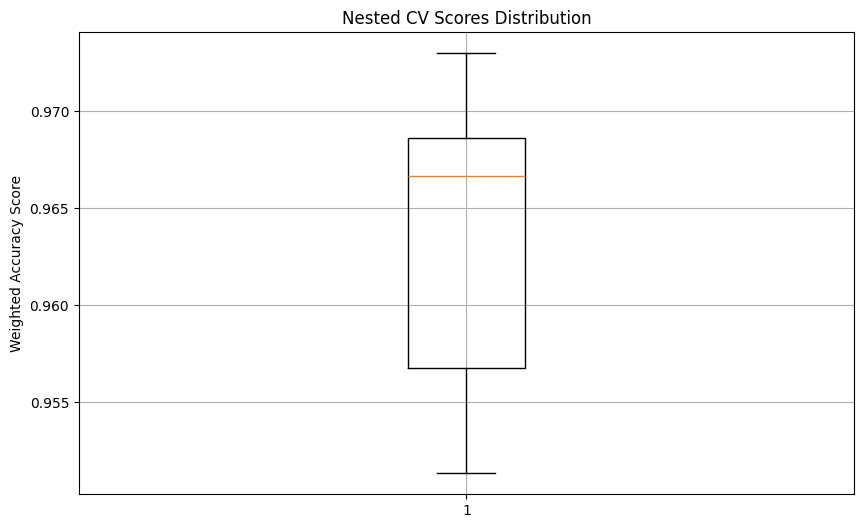


Nested CV Results:
Mean Score: 0.9633
Std Score: 0.0080

Scores per outer fold:
Fold 1: 0.9730
Fold 2: 0.9686
Fold 3: 0.9514
Fold 4: 0.9568
Fold 5: 0.9667


/tmp/ipykernel_48728/347682116.py:83: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([nested_scores, regular_scores], labels=['Nested CV', 'Regular CV'])


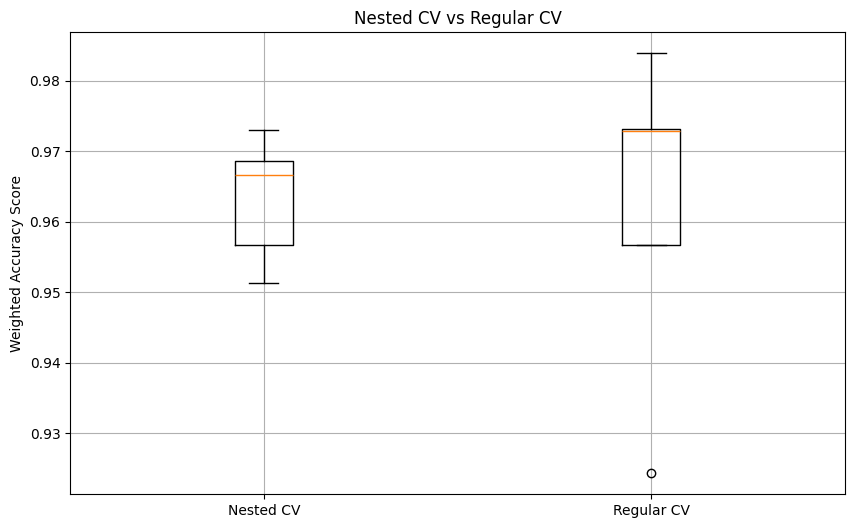


Comparison of CV Methods:
------------------------------
Nested CV:
Mean: 0.9633
Std: 0.0080

Regular CV:
Mean: 0.9622
Std: 0.0208


In [91]:
# 1. Custom Scoring Function
def custom_weighted_accuracy(y_true, y_pred, weights={0: 1, 1: 2}):
    """
    Custom weighted accuracy yang memberikan bobot berbeda untuk setiap kelas
    """
    correct = y_true == y_pred
    class_weights = np.array([weights[y] for y in y_true])
    return np.sum(correct * class_weights) / np.sum(class_weights)

# Buat scorer
weighted_accuracy_scorer = make_scorer(custom_weighted_accuracy)

# 2. Nested Cross-Validation
def nested_cv(X, y, inner_cv=5, outer_cv=5):
    # Parameter grid untuk inner CV
    param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [5, 10, None],
        'min_samples_split': [2, 5]
    }
    
    # Outer CV scores
    outer_scores = []
    
    # Outer CV
    outer_cv_split = KFold(n_splits=outer_cv, shuffle=True, random_state=42)
    
    for train_idx, test_idx in outer_cv_split.split(X):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        
        # Inner CV (Grid Search)
        inner_cv_split = KFold(n_splits=inner_cv, shuffle=True, random_state=42)
        
        # Create and fit GridSearchCV
        model = RandomForestClassifier(random_state=42)
        grid_search = GridSearchCV(
            model, param_grid, cv=inner_cv_split,
            scoring=weighted_accuracy_scorer
        )
        grid_search.fit(X_train, y_train)
        
        # Evaluate on test set
        score = custom_weighted_accuracy(
            y_test,
            grid_search.predict(X_test)
        )
        outer_scores.append(score)
        
    return outer_scores

# Run nested CV
nested_scores = nested_cv(X, y)

# Visualize results
plt.figure(figsize=(10, 6))
plt.boxplot(nested_scores)
plt.title('Nested CV Scores Distribution')
plt.ylabel('Weighted Accuracy Score')
plt.grid(True)
plt.show()

print("\nNested CV Results:")
print(f"Mean Score: {np.mean(nested_scores):.4f}")
print(f"Std Score: {np.std(nested_scores):.4f}")
print("\nScores per outer fold:")
for i, score in enumerate(nested_scores, 1):
    print(f"Fold {i}: {score:.4f}")

# 3. Compare with regular CV
def regular_cv(X, y, cv=5):
    model = RandomForestClassifier(random_state=42)
    scores = cross_val_score(
        model, X, y, cv=cv,
        scoring=weighted_accuracy_scorer
    )
    return scores

regular_scores = regular_cv(X, y)

# Plot comparison
plt.figure(figsize=(10, 6))
plt.boxplot([nested_scores, regular_scores], labels=['Nested CV', 'Regular CV'])
plt.title('Nested CV vs Regular CV')
plt.ylabel('Weighted Accuracy Score')
plt.grid(True)
plt.show()

print("\nComparison of CV Methods:")
print("-" * 30)
print("Nested CV:")
print(f"Mean: {np.mean(nested_scores):.4f}")
print(f"Std: {np.std(nested_scores):.4f}")
print("\nRegular CV:")
print(f"Mean: {np.mean(regular_scores):.4f}")
print(f"Std: {np.std(regular_scores):.4f}")

# Kesimpulan dan Best Practices

## 1. Pemilihan Metode CV
- Gunakan Stratified K-Fold untuk klasifikasi
- Time Series CV untuk data temporal
- Nested CV untuk model selection dan tuning

## 2. Hyperparameter Tuning
- Grid Search untuk parameter space kecil
- Random Search untuk parameter space besar
- Gunakan parameter distributions yang masuk akal

## 3. Feature Selection
- Lakukan feature selection dalam CV loop
- Monitor stabilitas feature selection
- Pertimbangkan domain knowledge

## 4. Custom Metrics
- Sesuaikan dengan kebutuhan bisnis
- Kombinasikan multiple metrics jika perlu
- Validasi metric implementation

## Tips Implementasi
1. Selalu set random seed untuk reproducibility
2. Gunakan parallel processing untuk efisiensi
3. Monitor waktu komputasi
4. Simpan intermediate results

## Common Pitfalls
1. Data leakage dalam preprocessing
2. Overfitting pada validation set
3. Tidak mempertimbangkan karakteristik data
4. Terlalu kompleks tanpa benefit signifikan

## Next Steps
1. Implementasi pada dataset real
2. Eksperimen dengan metrik custom
3. Optimasi computational efficiency
4. Integrasi dengan pipeline produksi